In [85]:
# Pillow is installed but import PIL due to backward dependency
from PIL import Image
from tesserocr import PyTessBaseAPI, RIL
from IPython.display import Image as Imagex 
import re

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [86]:
base = '/Users/macbook/Documents/RAVI/Notebook/'

In [87]:
def dist(x1, y1, x2, y2):
    return (x2-x1)**2 + (y2-y1)**2

In [88]:
class Label:
    """Class for the identified labels"""
    
    def __init__(self, x, y, w, h, confidence, text):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.confidence = confidence
        self.text = text
        
    def getX(self):
        return self.x
    
    def getY(self):
        return self.y
    
    def getW(self):
        return self.w
    
    def getH(self):
        return self.h
    
    def getConfidence(self):
        return self.confidence
    
    def getText(self):
        return self.text
    
    def updateText(self, newtext):
        self.text = newtext

In [100]:
def fn(x):
    x = re.sub(' +',' ',x)
    return " ".join(x.split())

(129, 145, 176, 32, 82, u'containing')
(129, 178, 961, 39, 87, u'Wire gauze\n\n \n\ncopper power')
(906, 277, 217, 32, 87, u'Tripod stand')
(907, 384, 120, 23, 85, u'Burner')
(115, 691, 253, 41, 91, u'Figure 1 .10')
(118, 734, 1015, 57, 82, u'Oxidation of copper to 2Cu + 02 \ufb02')
(117, 793, 241, 39, 83, u'copper oxide')

Pair: containing, Wire gauze copper power
Region 3

Pair: containing, Tripod stand
Region 0

Pair: containing, Burner
Region 0

Pair: Wire gauze copper power, Tripod stand
Region 0

Pair: Wire gauze copper power, Burner
Region 0

Pair: Tripod stand, Burner
Region 3

Pair: Burner, containing
Region 1

Pair: Burner, Wire gauze copper power
Region 1



-------------------------------------------------
There are in total 4 text labels.
-------------------------------------------------------
-------------------------------------------------------
Image Caption : Oxidation of copper to 2Cu + 02 ﬂ copper oxide
-------------------------------------------------------
-------

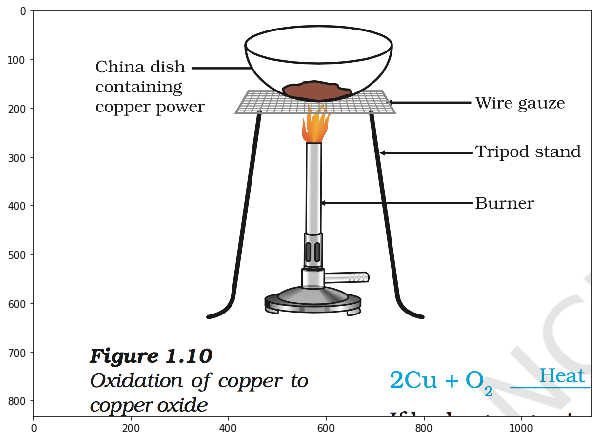

In [101]:
index = 2
path = base + str(index) + '.png'
image = Image.open(path)

img = mpimg.imread(path)
plt.figure(figsize=(10,50))
imgplot = plt.imshow(img)

# ----------------------------------------------------------------

api = PyTessBaseAPI()
api.SetImage(image)
boxes = api.GetComponentImages(RIL.TEXTLINE, True)
labels = []
caption = ''
b = False

# ----------------------------------------------------------------

"""im is a PIL image object"""
"""box is a dictionary with keys x, y, w and h"""

for i, (im, box, _, _) in enumerate(boxes):
    api.SetRectangle(box['x'], box['y'], box['w'], box['h'])
    ocrResult = api.GetUTF8Text()
    conf = api.MeanTextConf()

    if conf < 70: continue

    print (box['x'], box['y'], box['w'], box['h'], conf, ocrResult.strip())

    if b:
        caption = caption + " " + ocrResult.strip()
        caption = fn(caption)
        continue

    if ocrResult.strip().lower().startswith('fig'):
        b = True
        continue

    newLabel = Label(box['x'], box['y'], box['w'], box['h'], conf, fn(str(ocrResult.strip())))
    labels.append(newLabel)


# ----------------------------------------------------------------
pairs = set()
""" my_tuple = (3,5)"""
""" pairs.add(my_tuple)"""

descriptions = []


for i,label in enumerate(labels):
    my_x = label.getX()
    my_y = label.getY()

    ### maintaining info for all the 8 regions
    bx = [False]*8
    minx = [(-1,1000000000)]*8 
    """array of tuples (index,value)"""


    for j in range(0,len(labels)):

        # First check  if the pair already exists or not
        if i == j: continue
        if (i,j) in pairs or (j,i) in pairs: continue

        # Get the cordinates for the other point
        his_x = labels[j].getX()
        his_y = labels[j].getY()

        print ("\nPair: " + labels[i].getText() + ", " + labels[j].getText())
        """ 
        If its in the range of 20 degress above or below the direct direction
        x increases on the right and y increases towards bottom
        tan(20*) = 0.36 


        Go through all the labels only once
        For each label calculate in which of the 8 regions does it lie

        For each region maintain the closest one you have obtained till now
        Also if you have at all obtained any label from that region or not.

        In the end just add the details of those closest ones from each region.
        """



        if his_x > my_x  and abs(his_y-my_y)/(his_x-my_x) <  0.36:    
            """ Right """
            k = 0
            d = dist(my_x, my_y, his_x, his_y)
            if bx[k]:
                if d < minx[k][1]:
                    minx[k] = (j,d)
            else:
                bx[k] = True
                minx[k] = (j,d)

            print ("Region " + str(k))

        elif his_x < my_x and abs(his_y-my_y)/(my_x-his_x) <  0.36:
            """ Left """
            k = 1
            d = dist(my_x, my_y, his_x, his_y)
            if bx[k]:
                if d < minx[k][1]:
                    minx[k] = (j,d)
            else:
                bx[k] = True
                minx[k] = (j,d)

            print ("Region " + str(k))

        elif his_y < my_y and abs(his_x-my_x)/(my_y-his_y) <  0.36:
            """ Top """
            k = 2
            d = dist(my_x, my_y, his_x, his_y)
            if bx[k]:
                if d < minx[k][1]:
                    minx[k] = (j,d)
            else:
                bx[k] = True
                minx[k] = (j,d)

            print ("Region " + str(k))

        elif his_y > my_y and abs(his_x-my_x)/(his_y-my_y) <  0.36:
            """ Bottom """
            k = 3
            d = dist(my_x, my_y, his_x, his_y)
            if bx[k]:
                if d < minx[k][1]:
                    minx[k] = (j,d)
            else:
                bx[k] = True
                minx[k] = (j,d)

            print ("Region " + str(k))

        elif his_x > my_x and his_y < my_y:
            """ Top Right """
            k = 4
            d = dist(my_x, my_y, his_x, his_y)
            if bx[k]:
                if d < minx[k][1]:
                    minx[k] = (j,d)
            else:
                bx[k] = True
                minx[k] = (j,d)

            print ("Region " + str(k))

        elif his_x > my_x and his_y > my_y:
            """ Bottom Right """
            k = 5
            d = dist(my_x, my_y, his_x, his_y)
            if bx[k]:
                if d < minx[k][1]:
                    minx[k] = (j,d)
            else:
                bx[k] = True
                minx[k] = (j,d)

            print ("Region " + str(k)) 

        elif his_x < my_x and his_y < my_y:
            """ Top Left """
            k = 6
            d = dist(my_x, my_y, his_x, his_y)
            if bx[k]:
                if d < minx[k][1]:
                    minx[k] = (j,d)
            else:
                bx[k] = True
                minx[k] = (j,d)

            print ("Region " + str(k)) 

        elif his_x < my_x and his_y > my_y:
            """ Bottom Left """
            k = 7
            d = dist(my_x, my_y, his_x, his_y)
            if bx[k]:
                if d < minx[k][1]:
                    minx[k] = (j,d)
            else:
                bx[k] = True
                minx[k] = (j,d)

            print ("Region " + str(k))


    ### Add all the 8 regions best ones into the pairs set.
    for j in range(8):
#         print ("j is " + str(j))
#         print ("bx[j] is " + str(bx[j]))
        if bx[j]:
            pairs.add((i,minx[j][0]))

            """For each case, add the Description"""
            if j==0:
                s = labels[minx[j][0]].getText() + " is on the right of " + labels[i].getText()
                descriptions.append(s)
            elif j==1:
                s = labels[minx[j][0]].getText() + " is on the left of " + labels[i].getText()
                descriptions.append(s)
            elif j==2:
                s = labels[minx[j][0]].getText() + " is on the top of " + labels[i].getText()
                descriptions.append(s)
            elif j==3:
                s = labels[minx[j][0]].getText() + " is on the bottom of " + labels[i].getText()
                descriptions.append(s)
            elif j==4:
                s = labels[minx[j][0]].getText() + " is on the top right of " + labels[i].getText()
                descriptions.append(s)
            elif j==5:
                s = labels[minx[j][0]].getText() + " is on the bottom right of " + labels[i].getText()
                descriptions.append(s)
            elif j==6:
                s = labels[minx[j][0]].getText() + " is on the top left of " + labels[i].getText()
                descriptions.append(s)
            elif j==7:
                s = labels[minx[j][0]].getText() + " is on the bottom left of " + labels[i].getText()
                descriptions.append(s)





# ----------------------------------------------------------------
# ----------------------------------------------------------------


print '\n\n\n-------------------------------------------------'
print 'There are in total {} text labels.'.format(len(labels))
print '-------------------------------------------------------'

print '-------------------------------------------------------'
print ('Image Caption : ' + caption)
print '-------------------------------------------------------'

print '-------------------------------------------------------'
print '----------------------LABELS---------------------------'

for label in labels:
    print label.getText()

print '-------------------------------------------------------'
print '-------------------------------------------------------'
print '-----------------RELATIVE POSITIONS--------------------'
for description in descriptions:
    print description


In [55]:
pairs

{(0, 1), (0, 2), (1, 2), (2, 3), (3, 1)}

### Finally output all the things one by one: 
- The No. of labels
- The Caption
- The Labels itself
- The Relative positions pairwise

In [32]:
a = [False]*9
a

[False, False, False, False, False, False, False, False, False]

In [33]:
mix = [(-1,1000000000)]*8
mix

[(-1, 1000000000),
 (-1, 1000000000),
 (-1, 1000000000),
 (-1, 1000000000),
 (-1, 1000000000),
 (-1, 1000000000),
 (-1, 1000000000),
 (-1, 1000000000)]